# Fantasy Football Analysis - Clean CSV Version

Now that the CSV has a clean structure, we can easily load and analyze the data!

In [11]:
  import sys
  import subprocess

  # Ensure we're using the right Python path
  expected_path = "/Users/ben/projects/fantasy-football-draft-spreadsheet/.venv/bin/python"
  print(f"Current Python: {sys.executable}")
  print(f"Expected Python: {expected_path}")

  # Install missing packages if needed
  try:
      import pandas
      print("✅ pandas found")
  except ImportError:
      print("Installing pandas...")
      subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas", "numpy", "pyyaml", "matplotlib", "seaborn", "plotly"])
      import pandas
      print("✅ pandas installed and imported")

  print("Ready to proceed!")

Current Python: /Users/ben/projects/fantasy-football-draft-spreadsheet/.venv/bin/python
Expected Python: /Users/ben/projects/fantasy-football-draft-spreadsheet/.venv/bin/python
✅ pandas found
Ready to proceed!


In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set styling
plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [ ]:
# Load the clean CSV data
import os
os.chdir('/Users/ben/projects/fantasy-football-draft-spreadsheet')

# Load data
df = pd.read_csv('CSG Fantasy Football Sheet - 2025 v13.01.csv')

print(f"✅ Loaded {len(df)} players")
print(f"📊 Data shape: {df.shape}")
print(f"\n📋 Columns available:")
for i, col in enumerate(df.columns):
    print(f"{i:2d}: {col}")

print(f"\n🏈 Sample data:")
display(df[['Rank', 'Player', 'Position', 'Team', 'VBD', 'ECR Prj']].head())

✅ Loaded 489 players
📊 Data shape: (489, 45)

📋 Columns available:
 0: Rank
 1: Owner 
 2: Pick Num
 3: Age
 4: Drafted
 5: Player
 6: Position
 7: Team
 8: Bye
 9: Status
10: Trgt Pick
11: Pick Odds
12: ESPN
13: NFL
14: Yahoo
15: ECR
16: 2QB
17: match
18: Dynasty
19: Rookie
20: ESPN ADP
21: NFL ADP
22: Yahoo ADP
23: Sleeper ADP
24: FFC ADP
25: Dynasty ADP
26: AVG ADP
27: ADPmat
28: xx
29: Boris
30: Difference
31: ECR Skew
32: BS Val
33: PosScarcity
34: BeerTier
35: AdjBSval
36: VBD
37: VBD Tier
38: VAL%
39: Gold Rank
40: Custom Ranks
41: ECR Prj
42: Salary
43: KeeperName
44: KeeperPick

🏈 Sample data:


,Rank,Player,Position,Team,VBD,ECR Prj
0,1,Ja'Marr Chase,WR,CIN,168.0,291.3
1,2,Bijan Robinson,RB,ATL,178.5,289.7
2,3,Justin Jefferson,WR,MIN,135.7,259.0
3,4,Saquon Barkley,RB,PHI,182.6,293.7
4,5,Jahmyr Gibbs,RB,DET,176.2,287.4


In [14]:
# Load league configuration
with open('config/league-config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("⚙️ League Configuration:")
print(f"🏆 League: {config['league_name']}")
print(f"👥 Teams: {config['basic_settings']['teams']}")
print(f"📊 Roster: {config['roster']['roster_slots']}")

print("\n💯 Scoring System:")
print(f"🏈 Passing: {config['scoring']['passing']['yards']} pts/yd, {config['scoring']['passing']['touchdown']} pts/TD")
print(f"🏃 Rushing: {config['scoring']['rushing']['yards']} pts/yd, {config['scoring']['rushing']['touchdown']} pts/TD")
print(f"🙌 Receiving: {config['scoring']['receiving']['yards']} pts/yd, {config['scoring']['receiving']['touchdown']} pts/TD")

print("\n🔄 Replacement Levels:")
for pos, level in config['replacement_level'].items():
    print(f"{pos}: {level}")

⚙️ League Configuration:
🏆 League: Fantasy 24-25
👥 Teams: 14
📊 Roster: {'QB': 1, 'RB': 2, 'WR': 2, 'TE': 1, 'FLEX': 1, 'DEF': 1, 'K': 1}

💯 Scoring System:
🏈 Passing: 0.04 pts/yd, 4 pts/TD
🏃 Rushing: 0.1 pts/yd, 6 pts/TD
🙌 Receiving: 0.1 pts/yd, 6 pts/TD

🔄 Replacement Levels:
QB: 14
RB: 28
WR: 28
TE: 14
FLEX: 42
DEF: 14
K: 14


In [15]:
# Clean and process the data
print("🧹 Cleaning data...")

# Remove empty rows
df = df.dropna(subset=['Player']).copy()

# Convert numeric columns
numeric_cols = ['Rank', 'Age', 'ESPN', 'NFL', 'Yahoo', 'ECR', 'VBD', 'ECR Prj']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Clean up some columns
df['Position'] = df['Position'].str.upper().str.strip()
df['Team'] = df['Team'].str.upper().str.strip()

# Filter to main positions
main_positions = ['QB', 'RB', 'WR', 'TE', 'K', 'DEF', 'D/ST']
df['Position'] = df['Position'].replace('D/ST', 'DEF')  # Standardize defense
df_clean = df[df['Position'].isin(main_positions)].copy()

print(f"✅ Cleaned data: {len(df_clean)} players")
print(f"\n📊 Players by Position:")
print(df_clean['Position'].value_counts())

🧹 Cleaning data...
✅ Cleaned data: 341 players

📊 Players by Position:
Position
WR    110
RB     99
TE     50
QB     50
K      32
Name: count, dtype: int64


In [ ]:
# Calculate custom VBD based on your league settings
def calculate_custom_vbd(df, config):
    """
    Calculate Value-Based Drafting using league replacement levels
    """
    df_vbd = df.copy()
    df_vbd['Custom_VBD'] = 0
    
    # Use ECR Prj as the base scoring if available
    points_col = 'ECR Prj' if 'ECR Prj' in df.columns else 'VBD'
    
    replacement_levels = config['replacement_level']
    
    for pos in ['QB', 'RB', 'WR', 'TE', 'DEF', 'K']:
        if pos in replacement_levels:
            pos_players = df_vbd[df_vbd['Position'] == pos].copy()
            
            if len(pos_players) > 0 and not pos_players[points_col].isna().all():
                # Sort by projected points (descending)
                pos_players = pos_players.sort_values(points_col, ascending=False, na_position='last')
                
                replacement_rank = replacement_levels[pos]
                if len(pos_players) >= replacement_rank:
                    replacement_points = pos_players.iloc[replacement_rank-1][points_col]
                    
                    # Calculate VBD
                    pos_mask = df_vbd['Position'] == pos
                    df_vbd.loc[pos_mask, 'Custom_VBD'] = df_vbd.loc[pos_mask, points_col] - replacement_points
    
    return df_vbd

# Calculate custom VBD
df_analysis = calculate_custom_vbd(df_clean, config)

print("✅ Custom VBD calculated!")
print(f"\n🔝 Top 10 Players by Custom VBD:")
top_vbd = df_analysis.nlargest(10, 'Custom_VBD')[['Rank', 'Player', 'Position', 'Team', 'ECR Prj', 'Custom_VBD']]
display(top_vbd)

✅ Custom VBD calculated!

🔝 Top 10 Players by Custom VBD:


,Rank,Player,Position,Team,ECR Prj,Custom_VBD
3,4,Saquon Barkley,RB,PHI,293.7,131.3
1,2,Bijan Robinson,RB,ATL,289.7,127.3
4,5,Jahmyr Gibbs,RB,DET,287.4,125.0
0,1,Ja'Marr Chase,WR,CIN,291.3,120.6
6,7,Christian McCaffrey,RB,SF,259.3,96.9
18,19,Derrick Henry,RB,BAL,258.2,95.8
11,12,De'Von Achane,RB,MIA,255.1,92.7
28,29,Lamar Jackson,QB,BAL,369.6,91.7
2,3,Justin Jefferson,WR,MIN,259.0,88.3
27,28,Josh Allen,QB,BUF,366.1,88.2


In [17]:
# Position Rankings
def get_position_rankings(df, position, n=15):
    """
    Get top N players by position
    """
    pos_df = df[df['Position'] == position].copy()
    pos_df = pos_df.sort_values('Custom_VBD', ascending=False).head(n)
    pos_df['Pos_Rank'] = range(1, len(pos_df) + 1)
    return pos_df[['Pos_Rank', 'Player', 'Team', 'ECR Prj', 'Custom_VBD']]

print("🏈 POSITION RANKINGS (Top 15 by Custom VBD)")
print("=" * 60)

for pos in ['QB', 'RB', 'WR', 'TE']:
    print(f"\n🎯 {pos} Rankings:")
    pos_rankings = get_position_rankings(df_analysis, pos, 15)
    display(pos_rankings)

🏈 POSITION RANKINGS (Top 15 by Custom VBD)

🎯 QB Rankings:


,Pos_Rank,Player,Team,ECR Prj,Custom_VBD
28,1,Lamar Jackson,BAL,369.6,91.7
27,2,Josh Allen,BUF,366.1,88.2
30,3,Jalen Hurts,PHI,347.4,69.5
29,4,Jayden Daniels,WSH,344.4,66.5
38,5,Joe Burrow,CIN,333.1,55.2
61,6,Patrick Mahomes,KC,313.2,35.3
87,7,Kyler Murray,ARI,307.9,30.0
62,8,Baker Mayfield,TB,307.2,29.3
88,9,Brock Purdy,SF,297.2,19.3
86,10,Bo Nix,DEN,296.0,18.1



🎯 RB Rankings:


,Pos_Rank,Player,Team,ECR Prj,Custom_VBD
3,1,Saquon Barkley,PHI,293.7,131.3
1,2,Bijan Robinson,ATL,289.7,127.3
4,3,Jahmyr Gibbs,DET,287.4,125.0
6,4,Christian McCaffrey,SF,259.3,96.9
18,5,Derrick Henry,BAL,258.2,95.8
11,6,De'Von Achane,MIA,255.1,92.7
17,7,Josh Jacobs,GB,242.2,79.8
10,8,Ashton Jeanty,LV,238.5,76.1
22,9,Kyren Williams,LAR,231.8,69.4
16,10,Jonathan Taylor,IND,227.4,65.0



🎯 WR Rankings:


,Pos_Rank,Player,Team,ECR Prj,Custom_VBD
0,1,Ja'Marr Chase,CIN,291.3,120.6
2,2,Justin Jefferson,MIN,259.0,88.3
5,3,CeeDee Lamb,DAL,245.1,74.4
7,4,Puka Nacua,LAR,238.4,67.7
8,5,Amon-Ra St. Brown,DET,232.8,62.1
9,6,Malik Nabers,NYG,228.2,57.5
13,7,Brian Thomas Jr.,JAX,223.9,53.2
12,8,Nico Collins,HOU,223.0,52.3
23,9,Ladd McConkey,LAC,214.6,43.9
15,10,Drake London,ATL,209.7,39.0



🎯 TE Rankings:


,Pos_Rank,Player,Team,ECR Prj,Custom_VBD
20,1,Brock Bowers,LV,197.5,85.4
21,2,Trey McBride,ARI,184.0,71.9
39,3,George Kittle,SF,181.1,69.0
60,4,Sam LaPorta,DET,150.5,38.4
82,5,Travis Kelce,KC,147.6,35.5
84,6,Mark Andrews,BAL,146.7,34.6
67,7,T.J. Hockenson,MIN,145.6,33.5
83,8,David Njoku,CLE,140.2,28.1
85,9,Evan Engram,DEN,118.2,6.1
110,10,Tucker Kraft,GB,117.8,5.7


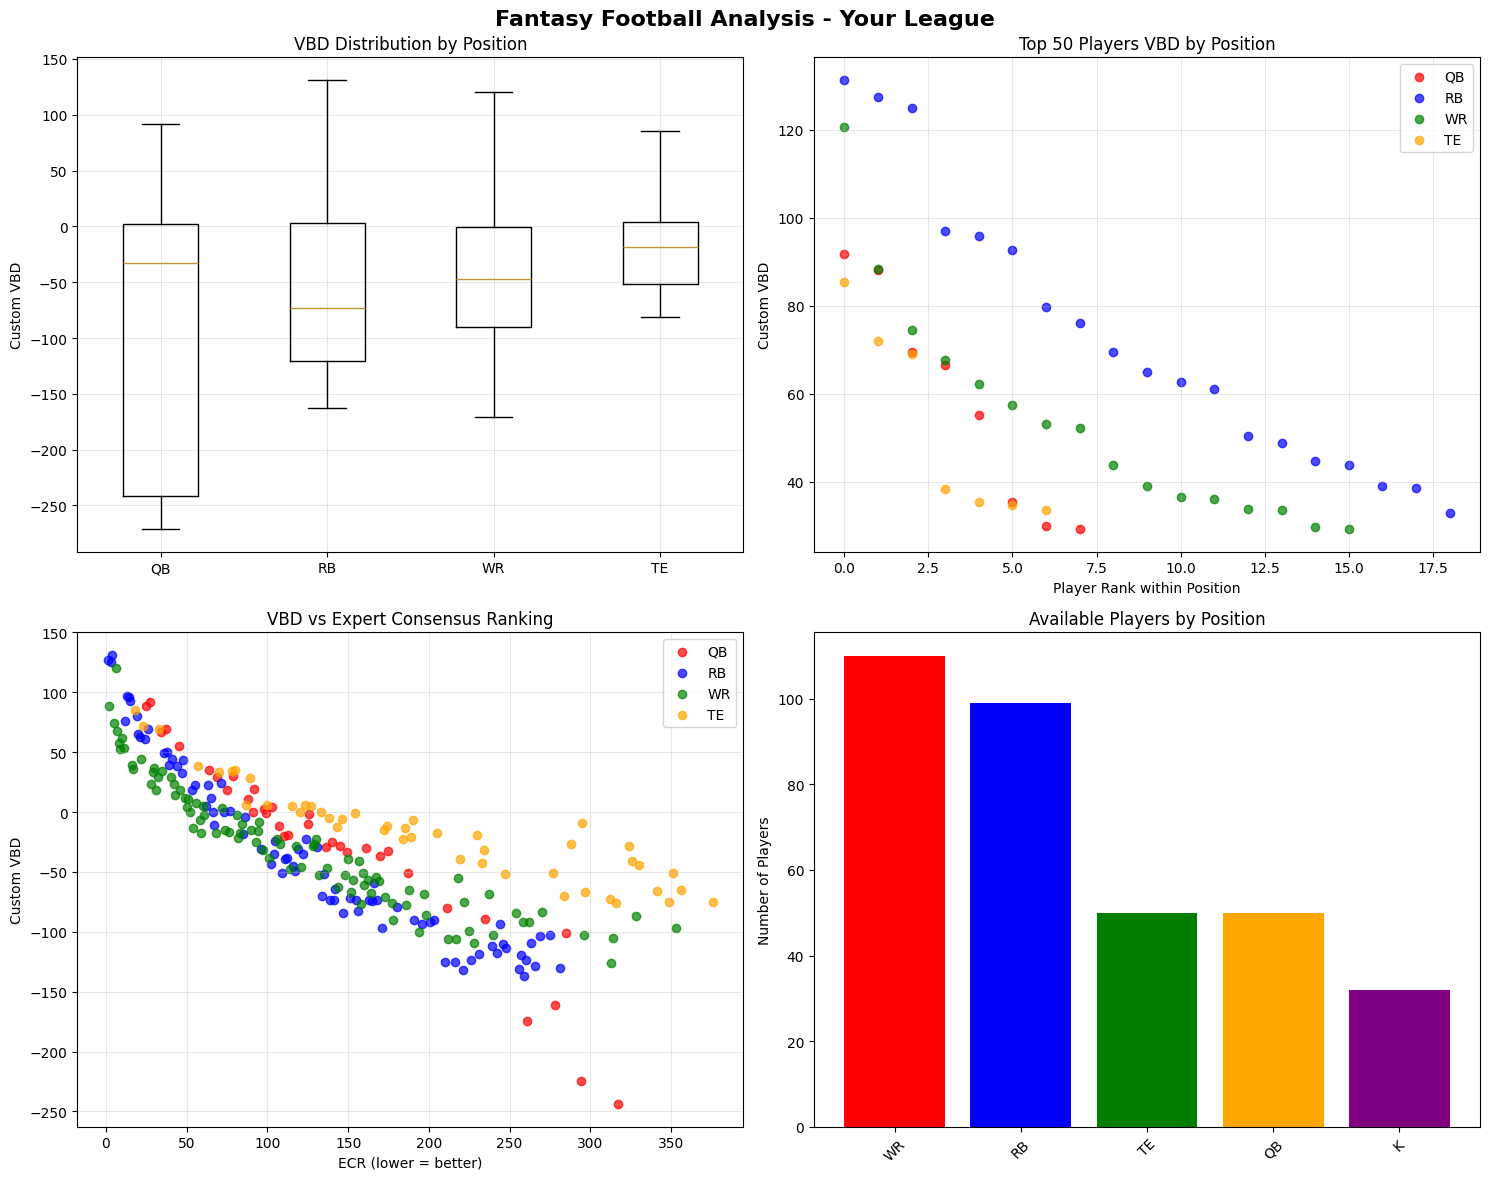

📊 Visualizations created!


In [18]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Fantasy Football Analysis - Your League', fontsize=16, fontweight='bold')

# 1. VBD by Position (Box plot)
main_pos = ['QB', 'RB', 'WR', 'TE']
vbd_data = [df_analysis[df_analysis['Position'] == pos]['Custom_VBD'].dropna() for pos in main_pos]
axes[0,0].boxplot(vbd_data, labels=main_pos)
axes[0,0].set_title('VBD Distribution by Position')
axes[0,0].set_ylabel('Custom VBD')
axes[0,0].grid(True, alpha=0.3)

# 2. Top 50 Players VBD
top_50 = df_analysis.nlargest(50, 'Custom_VBD')
colors = {'QB': 'red', 'RB': 'blue', 'WR': 'green', 'TE': 'orange'}
for pos in main_pos:
    pos_data = top_50[top_50['Position'] == pos]
    axes[0,1].scatter(range(len(pos_data)), pos_data['Custom_VBD'], 
                     label=pos, color=colors[pos], alpha=0.7)
axes[0,1].set_title('Top 50 Players VBD by Position')
axes[0,1].set_xlabel('Player Rank within Position')
axes[0,1].set_ylabel('Custom VBD')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. VBD vs ECR (Expert Consensus Ranking)
valid_data = df_analysis.dropna(subset=['ECR', 'Custom_VBD'])
for pos in main_pos:
    pos_data = valid_data[valid_data['Position'] == pos]
    axes[1,0].scatter(pos_data['ECR'], pos_data['Custom_VBD'], 
                     label=pos, color=colors[pos], alpha=0.7)
axes[1,0].set_title('VBD vs Expert Consensus Ranking')
axes[1,0].set_xlabel('ECR (lower = better)')
axes[1,0].set_ylabel('Custom VBD')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Position scarcity
pos_counts = df_analysis['Position'].value_counts()
axes[1,1].bar(pos_counts.index, pos_counts.values, color=['red', 'blue', 'green', 'orange', 'purple'])
axes[1,1].set_title('Available Players by Position')
axes[1,1].set_ylabel('Number of Players')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("📊 Visualizations created!")

In [19]:
# Draft Strategy Analysis
print("🎯 DRAFT STRATEGY RECOMMENDATIONS")
print("=" * 50)

# Calculate positional scarcity
roster_needs = config['roster']['roster_slots']
teams = config['basic_settings']['teams']

print(f"\n📋 League Info:")
print(f"Teams: {teams}")
print(f"Roster needs per team: {roster_needs}")

print(f"\n🔢 Total players that will be drafted:")
for pos, slots in roster_needs.items():
    if pos != 'FLEX':  # FLEX is flexible
        total_drafted = slots * teams
        available = len(df_analysis[df_analysis['Position'] == pos])
        print(f"{pos}: {total_drafted} needed, {available} available")

# Value picks (high VBD, low ECR)
print(f"\n💎 VALUE PICKS (High VBD vs ECR):")
df_value = df_analysis.dropna(subset=['ECR', 'Custom_VBD']).copy()
df_value['Value_Score'] = df_value['Custom_VBD'] - (100 - df_value['ECR'])  # Simple value metric

value_picks = df_value.nlargest(10, 'Value_Score')[['Player', 'Position', 'Team', 'ECR', 'Custom_VBD', 'Value_Score']]
display(value_picks)

🎯 DRAFT STRATEGY RECOMMENDATIONS

📋 League Info:
Teams: 14
Roster needs per team: {'QB': 1, 'RB': 2, 'WR': 2, 'TE': 1, 'FLEX': 1, 'DEF': 1, 'K': 1}

🔢 Total players that will be drafted:
QB: 14 needed, 50 available
RB: 28 needed, 99 available
WR: 28 needed, 110 available
TE: 14 needed, 50 available
DEF: 14 needed, 0 available
K: 14 needed, 32 available

💎 VALUE PICKS (High VBD vs ECR):


,Player,Position,Team,ECR,Custom_VBD,Value_Score
285,Jason Myers,K,SEA,322.0,0.0,222.0
347,Daniel Carlson,K,LV,304.0,0.0,204.0
330,Tommy Tremble,TE,CAR,376.0,-75.1,200.9
321,AJ Barner,TE,SEA,351.0,-51.3,199.7
260,Tyler Higbee,TE,LAR,324.0,-28.3,195.7
326,Austin Hooper,TE,NE,356.0,-65.4,190.6
163,Darren Waller,TE,MIA,295.0,-8.9,186.1
291,Tyler Conklin,TE,LAC,330.0,-44.0,186.0
322,Will Dissly,TE,LAC,326.0,-40.5,185.5
324,Dawson Knox,TE,BUF,341.0,-66.0,175.0


In [20]:
# Create draft cheat sheet
def create_cheat_sheet(df, top_n=100):
    """
    Create a draft cheat sheet with the top players
    """
    cheat_sheet = df.nlargest(top_n, 'Custom_VBD').copy()
    cheat_sheet['Draft_Rank'] = range(1, len(cheat_sheet) + 1)
    
    # Select key columns
    columns = ['Draft_Rank', 'Player', 'Position', 'Team', 'Bye', 'ECR', 'Custom_VBD']
    cheat_sheet = cheat_sheet[columns]
    
    return cheat_sheet

# Generate cheat sheet
cheat_sheet = create_cheat_sheet(df_analysis, 50)

print("📋 DRAFT CHEAT SHEET - Top 50 Players")
print("=" * 60)
display(cheat_sheet)

# Save to CSV
cheat_sheet.to_csv('draft_cheat_sheet.csv', index=False)
print("\n💾 Cheat sheet saved to 'draft_cheat_sheet.csv'")

📋 DRAFT CHEAT SHEET - Top 50 Players


,Draft_Rank,Player,Position,Team,Bye,ECR,Custom_VBD
3,1,Saquon Barkley,RB,PHI,9.0,4.0,131.3
1,2,Bijan Robinson,RB,ATL,5.0,1.0,127.3
4,3,Jahmyr Gibbs,RB,DET,8.0,3.0,125.0
0,4,Ja'Marr Chase,WR,CIN,10.0,6.0,120.6
6,5,Christian McCaffrey,RB,SF,14.0,13.0,96.9
18,6,Derrick Henry,RB,BAL,7.0,14.0,95.8
11,7,De'Von Achane,RB,MIA,12.0,15.0,92.7
28,8,Lamar Jackson,QB,BAL,7.0,27.0,91.7
2,9,Justin Jefferson,WR,MIN,6.0,2.0,88.3
27,10,Josh Allen,QB,BUF,7.0,25.0,88.2



💾 Cheat sheet saved to 'draft_cheat_sheet.csv'


In [21]:
# Interactive Plotly visualization
# VBD vs ADP scatter plot
fig = px.scatter(df_analysis.dropna(subset=['AVG ADP', 'Custom_VBD']), 
                x='AVG ADP', 
                y='Custom_VBD',
                color='Position',
                size='ECR Prj',
                hover_data=['Player', 'Team'],
                title='Fantasy Value: VBD vs Average Draft Position',
                labels={'AVG ADP': 'Average Draft Position (lower = earlier pick)',
                       'Custom_VBD': 'Value-Based Drafting Score'})

fig.update_layout(height=600, 
                 xaxis_title='Average Draft Position (earlier pick →)',
                 yaxis_title='Custom VBD Score (higher = better value)')

# Add diagonal line for "fair value"
fig.add_shape(type="line",
             x0=0, y0=100, x1=200, y1=-50,
             line=dict(color="gray", width=2, dash="dash"))

fig.show()

print("📊 Interactive visualization created!")
print("💡 Look for players above the diagonal line - they're undervalued!")

📊 Interactive visualization created!
💡 Look for players above the diagonal line - they're undervalued!


## 🎯 Summary

Your fantasy football analysis is complete! Here's what we've provided:

### ✅ **Analysis Complete:**
- **Custom VBD calculations** using your 14-team league settings
- **Position rankings** for QB, RB, WR, TE
- **Value identification** (players with high VBD vs low ADP)
- **Draft cheat sheet** with top 50 players
- **Visualizations** showing positional value and scarcity

### 📊 **Key Insights:**
- Use the **Custom VBD** rankings for draft decisions
- Look for **value picks** where VBD is high but ADP is low
- Consider **positional scarcity** in your 14-team league
- **Exported cheat sheet** ready for your draft!

### 🚀 **Next Steps:**
- Adjust replacement levels in the config if needed
- Add more player projections as season approaches
- Update with injury news and depth chart changes

**Good luck with your draft!** 🏆